In [1]:
#Importing all necessary libraries for this execution
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from keras import backend as K
#Training a Deep Neural Network, and Saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
def plot_performance(data):
    fig, ax = plt.subplots(1,2 , figsize = (20,7))
    # summarize history for accuracy
    ax[0].plot(data.history['accuracy'])
    ax[0].plot(data.history['val_accuracy'])
    ax[0].set_title('model accuracy')
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    ax[1].plot(data.history['loss'], label =['loss'])
    ax[1].plot(data.history['val_loss'] ,label =['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend(['train', 'test'], loc='upper left')
    plt.show()

In [3]:
extracted_features_df = pd.read_csv("https://github.com/KaranAgrawal1509/Urban-Sound-Classification/raw/main/Metadata/MFCCs.csv")
extracted_features_df

,class,0,1,2,3,4,5,6,7,8,...,70,71,72,73,74,75,76,77,78,79
0,dog_bark,-211.93698,62.581203,-122.813150,-60.745293,-13.893760,-29.789835,-3.978875,11.682742,12.963830,...,0.324511,1.514106,2.155947,1.580951,-1.321769,-3.285912,-3.684266,0.075934,1.307521,1.510565
1,children_playing,-417.00520,99.336624,-42.995586,51.073326,9.853778,7.969693,11.197088,1.929117,7.030397,...,-0.042892,0.442094,-0.311315,0.749658,-1.185292,0.672009,-0.203904,0.843772,-1.600764,0.216213
2,children_playing,-452.39316,112.362530,-37.578068,43.195866,8.631844,15.379366,16.882149,1.233048,6.833122,...,-0.107935,0.836189,-0.866050,0.989036,0.166954,1.828340,-0.641306,1.170986,0.242448,0.228041
3,children_playing,-406.47922,91.196600,-25.043558,42.784520,11.586844,5.054164,12.431632,-1.599949,6.656064,...,-1.563005,1.110121,-0.831134,-0.202216,-1.031376,-0.573062,-1.235855,0.603222,-0.894410,0.474847
4,children_playing,-439.63873,103.862240,-42.658787,50.690277,12.209422,15.873465,11.729268,1.533585,11.292244,...,-1.517887,0.367679,-0.645478,0.970620,-0.021970,0.859087,-1.042097,-0.116440,-0.740542,0.843810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,car_horn,-391.37210,125.362390,-40.634056,25.899754,1.730347,5.575200,16.873087,7.889440,3.488613,...,-4.102539,1.591708,1.754115,2.055592,-1.289034,-0.265378,-0.251471,-0.389598,0.717945,1.088910
8728,car_horn,-339.42715,76.409096,-35.309883,41.984035,-22.963873,-13.623511,27.856026,-9.215819,-5.666291,...,-1.366996,1.735160,-1.416760,1.599422,0.131289,0.614055,0.021380,0.767239,-1.556029,0.282285
8729,car_horn,-297.31534,102.090260,-36.751080,26.816488,-0.249390,3.960868,11.113069,1.912290,0.677115,...,1.847145,3.558338,-0.992298,-1.373567,-2.257117,-0.712134,-1.614370,1.099659,-1.268688,0.166942
8730,car_horn,-336.92386,115.313900,-44.847100,24.968985,-9.888025,-2.154685,22.700090,0.234236,-0.122909,...,-1.912338,1.955025,-2.233400,-1.820418,-2.034626,-1.908629,-3.614250,1.244706,-2.809676,0.148261


In [4]:
# Concatenate columns 0-3 separated by commas into a new column 'Features'
extracted_features_df['feature'] = extracted_features_df.loc[:, '0':'79'].apply(lambda x: ','.join(x.astype(str)), axis=1)
# Convert comma-separated values into lists of numerical values
extracted_features_df['feature'] = extracted_features_df['feature'].apply(lambda x: [float(i) for i in x.split(',')])
cols_to_drop = [str(i) for i in range(80)]
extracted_features_df.drop(cols_to_drop, axis=1, inplace=True)
extracted_features_df

,class,feature
0,dog_bark,"[-211.93698, 62.581203, -122.81315, -60.745293..."
1,children_playing,"[-417.0052, 99.336624, -42.995586, 51.073326, ..."
2,children_playing,"[-452.39316, 112.36253, -37.578068, 43.195866,..."
3,children_playing,"[-406.47922, 91.1966, -25.043558, 42.78452, 11..."
4,children_playing,"[-439.63873, 103.86224, -42.658787, 50.690277,..."
...,...,...
8727,car_horn,"[-391.3721, 125.36239, -40.634056, 25.899754, ..."
8728,car_horn,"[-339.42715, 76.409096, -35.309883, 41.984035,..."
8729,car_horn,"[-297.31534, 102.09026, -36.75108, 26.816488, ..."
8730,car_horn,"[-336.92386, 115.3139, -44.8471, 24.968985, -9..."


In [5]:
#Split the dataset into independent and dependent dataset
x=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [6]:
#Shape of Independent Features
x.shape

(8732, 80)

In [7]:
#Shape of Dependent Features
y.shape

(8732,)

In [8]:
#One-Hot Encoding Dependent features to suit the use of Neural Networks
labelencoder=LabelEncoder()
labelencoder.fit(extracted_features_df['class'])
labelencoder_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
y=to_categorical(labelencoder.fit_transform(y))

In [9]:
#Created a mapping dictionary of Label and category
labelencoder_name_mapping

{'air_conditioner': 0,
 'car_horn': 1,
 'children_playing': 2,
 'dog_bark': 3,
 'drilling': 4,
 'engine_idling': 5,
 'gun_shot': 6,
 'jackhammer': 7,
 'siren': 8,
 'street_music': 9}

In [10]:
#Data Spliting for Training and Validation Purpose
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [11]:
### No of classes
num_labels=y.shape[1]

In [12]:
def create_dnn_model(activation='relu', dropout_rate=0.4, optimizer='adam'):
    # Define the model architecture
    dnn_model = Sequential()
    dnn_model.add(Dense(800, input_shape=(80, x.shape[1])))
    dnn_model.add(Activation(activation))
    dnn_model.add(Dropout(dropout_rate))
    dnn_model.add(Dense(400))
    dnn_model.add(Activation(activation))
    dnn_model.add(Dropout(dropout_rate))
    dnn_model.add(Dense(200))
    dnn_model.add(Activation(activation))
    dnn_model.add(Dropout(dropout_rate))
    dnn_model.add(Dense(100))
    dnn_model.add(Activation(activation))
    dnn_model.add(Dropout(dropout_rate))
    dnn_model.add(Dense(50))
    dnn_model.add(Activation(activation))
    dnn_model.add(Dropout(dropout_rate))
    dnn_model.add(Dense(num_labels))
    dnn_model.add(Activation('softmax'))
    dnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return dnn_model

In [13]:
# Create the KerasClassifier wrapper
model = KerasClassifier(build_fn=create_dnn_model, verbose=0)

# Define the hyperparameters to tune
param_grid = {
    'activation': ['relu', 'tanh'],
    'dropout_rate': [0.2, 0.4, 0.6],
    'optimizer': ['adam', 'sgd']
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(x_train, y_train)

# Print the best hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-13-61c9cd504485>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_dnn_model, verbose=0)


Best: 0.501785 using {'activation': 'tanh', 'dropout_rate': 0.2, 'optimizer': 'adam'}


In [14]:
# Create the DNN model with the best hyperparameters
best_activation = grid_result.best_params_['activation']
best_dropout_rate = grid_result.best_params_['dropout_rate']
best_optimizer = grid_result.best_params_['optimizer']
dnn_model = create_dnn_model(activation=best_activation, dropout_rate=best_dropout_rate, optimizer=best_optimizer)

# Fit the model to the training data
dnn_history = dnn_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=128)


Epoch 1/100


55/55 [==============================] - ETA: 0s - loss: 1.9049 - accuracy: 0.3306

55/55 [==============================] - 3s 27ms/step - loss: 1.9049 - accuracy: 0.3306 - val_loss: 1.4029 - val_accuracy: 0.5289
Epoch 2/100
55/55 [==============================] - 1s 23ms/step - loss: 1.3638 - accuracy: 0.5410 - val_loss: 1.0515 - val_accuracy: 0.6686
Epoch 3/100
55/55 [==============================] - 1s 21ms/step - loss: 1.1209 - accuracy: 0.6409 - val_loss: 0.8779 - val_accuracy: 0.7224
Epoch 4/100
55/55 [==============================] - 1s 24ms/step - loss: 0.9423 - accuracy: 0.6981 - val_loss: 0.7550 - val_accuracy: 0.7710
Epoch 5/100
55/55 [==============================] - 2s 34ms/step - loss: 0.8232 - accuracy: 0.7390 - val_loss: 0.6961 - val_accuracy: 0.7939
Epoch 6/100
55/55 [==============================] - 2s 28ms/step - loss: 0.7222 - accuracy: 0.7748 - val_loss: 0.6704 - val_accuracy: 0.7905
Epoch 7/100
55/55 [==============================] - 1s 22ms/step - loss: 0.6847 - accuracy: 0.7847 - val_loss: 0.6281 - val_accuracy: 0.8031
Epoch 8/100
55/55 

In [15]:
# Evaluate the model on the test data
test_loss, test_accuracy = dnn_model.evaluate(x_test, y_test)

# Print the evaluation metrics
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

55/55 [==============================] - 0s 4ms/step - loss: 0.3415 - accuracy: 0.9118
Test loss: 0.34147584438323975
Test accuracy: 0.9118489027023315


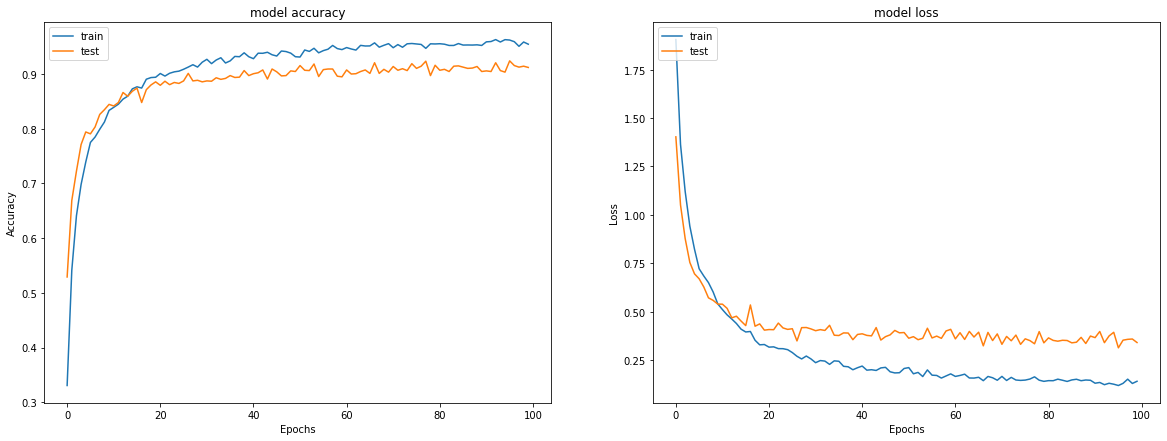

In [16]:
#Performance (Accuracy and Loss) of DNN during the training  
plot_performance(dnn_history)

In [17]:
# Get the predicted labels for the test data
dnn_predictions  = dnn_model.predict(x_test)

55/55 [==============================] - 0s 3ms/step


In [18]:
dnn_predictions = np.argmax(dnn_predictions, axis=1)
y_test=np.argmax(y_test, axis=1)

In [19]:
def get_key(val):
    for key, value in labelencoder_name_mapping.items():
        if val == value:
            return key

def mapping(predictions):
    new_list = []
    for i in predictions:
        new_list.append(get_key(i))
    return np.array(new_list)

In [20]:
#Mapping the output with actual label
dnn_predictions = mapping(dnn_predictions)

In [21]:
y_test = mapping(y_test)

In [22]:
class_names = np.unique(dnn_predictions)
class_names

array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark',
       'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren',
       'street_music'], dtype='<U16')

In [23]:
#Creating a Confusion Matrix to Evaluate the Model
import seaborn as sns
from sklearn.metrics import *
sns.set(rc={'figure.figsize':(11.7,8.27)})
dnn_matrix = confusion_matrix(y_test, dnn_predictions, labels = class_names)

In [24]:
dnn_cmtx = pd.DataFrame(
    dnn_matrix, 
    index=['true:{:}'.format(x) for x in class_names], 
    columns=['pred:{:}'.format(x) for x in class_names]
)

<AxesSubplot:>

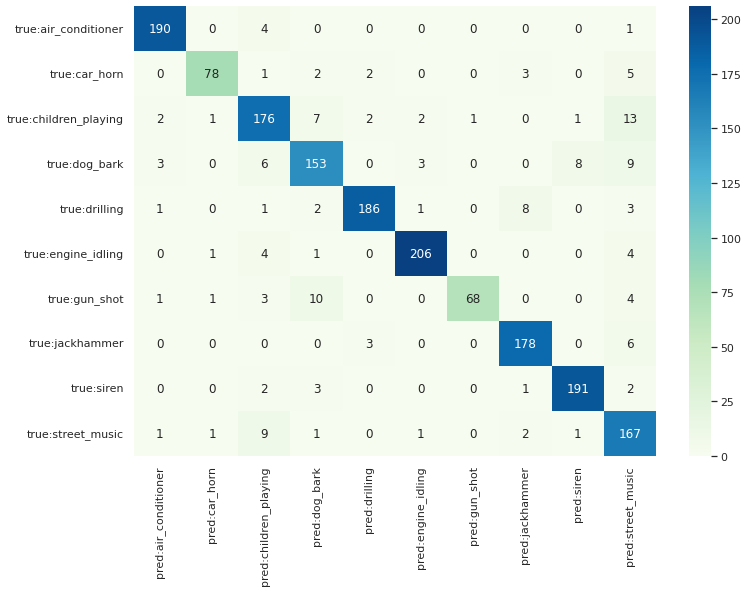

In [25]:
#Confusion Matrix for the Deep Learning Model on Features - MFCC's
sns.heatmap(dnn_cmtx, annot= True, cmap = 'GnBu', fmt='g')

In [26]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

labelencoder=LabelEncoder()
y = labelencoder.fit_transform(y)

In [27]:
#Splitting Data into Training and Test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  

In [28]:
#Initializing Random Forest Classifier and SVM
plt.rcParams["figure.figsize"] = (11.7,8.27)
forest_clf = RandomForestClassifier(max_depth=10, random_state=0)
svm_clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [29]:
from sklearn.model_selection import RandomizedSearchCV
# RandomForest hyperparameter tuning
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf_random_search = RandomizedSearchCV(RandomForestClassifier(random_state=0), rf_param_grid, n_iter=5, cv=3, n_jobs=-1)
rf_random_search.fit(x_train, y_train)
print("Best parameters for SVC: ", rf_random_search.best_params_)

Best parameters for SVC:  {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}


In [30]:
# Train RandomForest with the best parameters found by RandomizedSearchCV
forest_clf = RandomForestClassifier(**rf_random_search.best_params_)

In [31]:
# SVC hyperparameter tuning
svc_param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf', 'sigmoid'],
    'svc__gamma': ['scale', 'auto']
}

# Replace GridSearchCV with RandomizedSearchCV
svc_random_search = RandomizedSearchCV(make_pipeline(StandardScaler(), SVC()), svc_param_grid, n_iter=5, cv=3, n_jobs=-1)
svc_random_search.fit(x_train, y_train)
print("Best parameters for SVC: ", svc_random_search.best_params_)

Best parameters for SVC:  {'svc__kernel': 'rbf', 'svc__gamma': 'auto', 'svc__C': 10}


In [32]:
# Train SVC with the best parameters found by RandomizedSearchCV
best_svc_params = {key.replace("svc__", ""): value for key, value in svc_random_search.best_params_.items()}
svm_clf = make_pipeline(StandardScaler(), SVC(**best_svc_params))

In [33]:
#Function to Train Models
def run_models(model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print('Precision of the model is: %.3f' % precision_score(y_test, y_pred, average = 'micro'))
    print('Recall of the model is: %.3f' % recall_score(y_test, y_pred, average = 'macro'))
    print('F1 Score of the model: %.3f' % f1_score(y_test, y_pred, average = 'micro'))
    print('Accuracy of the model on testing data is: %.3f' % accuracy_score(y_test, y_pred))
    return np.array(mapping(y_pred))

In [34]:
#Evaluation of Random Forest on Test data
forest_matrix = confusion_matrix(mapping(y_test), run_models(forest_clf), labels = class_names)

Precision of the model is: 0.912
Recall of the model is: 0.898
F1 Score of the model: 0.912
Accuracy of the model on testing data is: 0.912


In [35]:
#Evaluation of SVM on Test data
svm_matrix = confusion_matrix(mapping(y_test), run_models(svm_clf), labels = class_names)

Precision of the model is: 0.943
Recall of the model is: 0.941
F1 Score of the model: 0.943
Accuracy of the model on testing data is: 0.943


In [36]:
forest_cmtx = pd.DataFrame(
    forest_matrix, 
    index=['true:{:}'.format(x) for x in class_names], 
    columns=['pred:{:}'.format(x) for x in class_names]
)

svm_cmtx = pd.DataFrame(
    svm_matrix, 
    index=['true:{:}'.format(x) for x in class_names], 
    columns=['pred:{:}'.format(x) for x in class_names]
)

<AxesSubplot:>

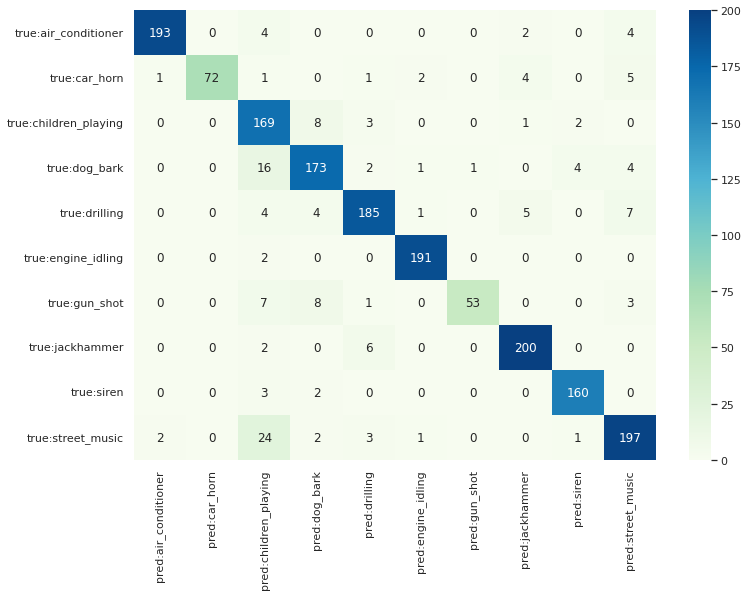

In [37]:
#Confusion Matrix for Random Forest on features - MFCC's
sns.heatmap(forest_cmtx, annot= True, cmap = 'GnBu', fmt='g')

<AxesSubplot:>

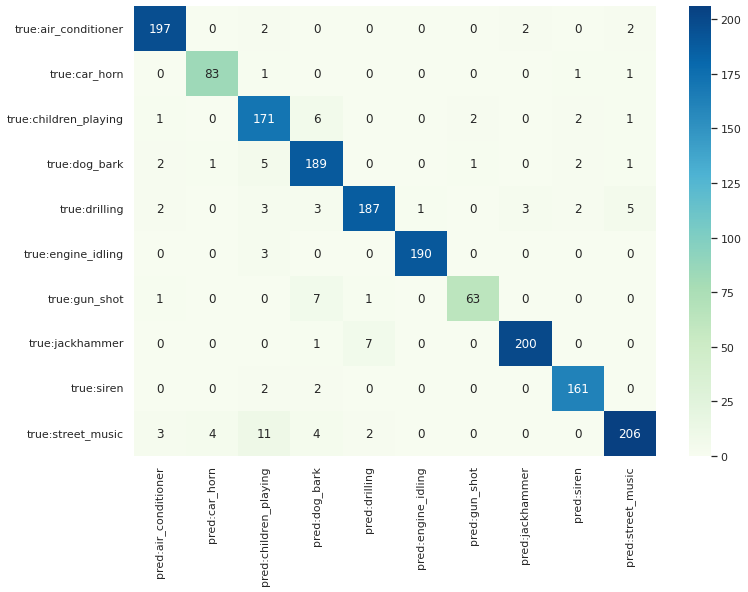

In [38]:
#Confusion Matrix for SVM on features - MFCC's
sns.heatmap(svm_cmtx, annot= True, cmap = 'GnBu', fmt='g')